In [1]:
# Cell 1: Bootstrap
import os, json, random, numpy as np, torch
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

for p in [
    'project/agents','project/tools','project/rl/policies','project/rl/bandits',
    'project/memory','project/envs','experiments/cfgs','experiments/runs',
    'experiments/checkpoints','docs','artifacts'
]:
    Path(p).mkdir(parents=True, exist_ok=True)

Path('requirements.txt').write_text("numpy\npandas\ntorch\nmatplotlib\n")

CFG_PPO = {"episodes": 600, "gamma": 0.99, "clip_eps": 0.2, "actor_lr": 3e-4, "critic_lr": 1e-3,
           "update_epochs": 4, "batch_size": 64}
CFG_BANDIT = {"alpha": 1.0}
json.dump(CFG_PPO, open('experiments/cfgs/ppo.json','w'), indent=2)
json.dump(CFG_BANDIT, open('experiments/cfgs/bandit.json','w'), indent=2)

print("✅ Skeleton ready.")


✅ Skeleton ready.


In [2]:
# Cell 1.1: Stronger PPO for long training
CFG_PPO.update({
    "episodes": 1000,
    "gamma": 0.99,
    "clip_eps": 0.2,
    "actor_lr": 3e-4,
    "critic_lr": 1e-3,
    "update_epochs": 5,
    "batch_size": 256,
    "gae_lambda": 0.95,
    "entropy_coef": 0.01,
    "max_grad_norm": 0.5
})
print("✅ PPO config strengthened:", CFG_PPO)


✅ PPO config strengthened: {'episodes': 1000, 'gamma': 0.99, 'clip_eps': 0.2, 'actor_lr': 0.0003, 'critic_lr': 0.001, 'update_epochs': 5, 'batch_size': 256, 'gae_lambda': 0.95, 'entropy_coef': 0.01, 'max_grad_norm': 0.5}


In [3]:
# Cell 2: Messaging + logging + retry + metrics
import time, csv
def now_ms(): return int(time.time()*1000)

MESSAGE_SCHEMA = {"role":"str", "intent":"str", "payload":"dict", "trace_id":"str", "ts":"int"}
def make_msg(role, intent, payload, trace_id):
    return {"role":role, "intent":intent, "payload":payload, "trace_id":trace_id, "ts":now_ms()}

def with_retries(fn, max_retries=2, sleep_s=0.01):
    tries=0
    while True:
        try: return fn()
        except Exception as e:
            if tries>=max_retries: raise
            tries+=1; time.sleep(sleep_s)

LOGS = []
def log_event(event_type, **kwargs):
    LOGS.append({"ts":now_ms(), "type":event_type, **kwargs})

def write_metrics_csv(path, rows, fieldnames):
    import csv, os
    os.makedirs(Path(path).parent, exist_ok=True)
    with open(path, 'w', newline='') as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        w.writeheader()
        for r in rows: w.writerow(r)


In [4]:
# Cell 3: Simple offline tutorial env
import math

TOPICS = ["algebra","probability","calculus","logic"]
DIFF_LEVELS = ["easy","medium","hard"]

def simulate_question(topic, difficulty):
    base = {"easy":0.8,"medium":0.6,"hard":0.4}[difficulty]
    noise = np.clip(np.random.normal(0,0.05), -0.1, 0.1)
    return max(0.05, min(0.95, base + noise))

def student_response(skill, difficulty, hint=0):
    diff_pen = {"easy":0.0,"medium":0.15,"hard":0.30}[difficulty]
    p = np.clip(skill - diff_pen + 0.1*hint, 0.05, 0.95)
    correct = np.random.rand() < p
    time_cost = np.random.uniform(2,7) + (0 if correct else 3)
    return int(correct), time_cost

class TutorialEnv:
    def __init__(self, horizon=100):
        self.horizon=horizon
        self.reset()
    def reset(self):
        self.step_idx=0
        self.skill=0.55
        self.last_correct=0
        self.last_time=5.0
        return self.observe()
    def observe(self):
        topic = TOPICS[self.step_idx % len(TOPICS)]
        return {
            "topic": topic, "difficulty": None,
            "last_correct": self.last_correct, "last_time": self.last_time,
            "skill_proxy": float(np.round(self.skill,3)), "step_idx": self.step_idx,
        }
    def act(self, difficulty, hint=0):
        topic = TOPICS[self.step_idx % len(TOPICS)]
        _ = simulate_question(topic, difficulty)
        correct, t = student_response(self.skill, difficulty, hint)
        if correct: self.skill = min(0.95, self.skill + 0.01)
        else: self.skill = max(0.30, self.skill - 0.002)
        r = (2.0 if correct else -1.0) + ({"easy":0,"medium":0.2,"hard":0.4}[difficulty]) - 0.1*t
        self.last_correct, self.last_time = correct, t
        self.step_idx += 1
        done = self.step_idx>=self.horizon
        info = {"topic":topic, "correct":correct, "time":t, "difficulty":difficulty, "hint":hint}
        return r, done, info


In [5]:
# Cell 4: Tools
class ToolError(Exception): pass

class BaseTool:
    name = "base"
    def validate_params(self, params:dict):
        if not isinstance(params, dict): raise ToolError(f"{self.name}: params must be dict")
    def __call__(self, **params): raise NotImplementedError

class SearchTool(BaseTool):
    name = "search"
    def validate_params(self, params):
        super().validate_params(params)
        q = params.get("query","")
        if not isinstance(q,str) or not q: raise ToolError("search: query required")
    def __call__(self, **params):
        self.validate_params(params)
        q = params["query"]
        return [{"title":f"{q} - note {i}", "score":1.0/(i+1)} for i in range(3)]

class SummarizeTool(BaseTool):
    name = "summarize"
    def validate_params(self, params):
        super().validate_params(params)
        text = params.get("text","")
        if not isinstance(text,str) or not text: raise ToolError("summarize: text required")
    def __call__(self, **params):
        self.validate_params(params)
        txt = params["text"]
        sents = txt.split(".")
        return {"summary": (sents[0][:120] + ("..." if len(sents[0])>120 else ""))}

class QuizBankTool(BaseTool):
    name = "quizbank"
    def validate_params(self, params):
        super().validate_params(params)
        topic = params.get("topic","")
        difficulty = params.get("difficulty","medium")
        if topic not in TOPICS: raise ToolError("quizbank: unknown topic")
        if difficulty not in DIFF_LEVELS: raise ToolError("quizbank: bad difficulty")
    def __call__(self, **params):
        self.validate_params(params)
        return {"question": f"({params['difficulty']}) {params['topic']} Q?"}

class DifficultyScaler(BaseTool):
    """Custom tool: proposes difficulty given last performance."""
    name = "difficulty_scaler"
    def validate_params(self, params):
        super().validate_params(params)
        lc = params.get("last_correct",0)
        lt = params.get("last_time",5.0)
        if lc not in [0,1]: raise ToolError("difficulty_scaler: last_correct must be 0/1")
        if not (0<=lt<=60): raise ToolError("difficulty_scaler: last_time out of range")
    def __call__(self, **params):
        self.validate_params(params)
        lc, lt = params["last_correct"], params["last_time"]
        if lc==1 and lt<5: return {"difficulty":"hard"}
        if lc==1: return {"difficulty":"medium"}
        return {"difficulty":"easy"}

# Tiny tests
try:
    SearchTool()(**{"query":"algebra"})
    SummarizeTool()(**{"text":"A. B. C."})
    QuizBankTool()(**{"topic":"algebra","difficulty":"easy"})
    DifficultyScaler()(**{"last_correct":1,"last_time":4.0})
    print("✅ Tools OK")
except Exception as e:
    print("❌ Tool test failed:", e)


✅ Tools OK


In [6]:
# Cell 5: Memory
class MemoryStore:
    def __init__(self, maxlen=1024):
        self.buf=[]
        self.maxlen=maxlen
    def add(self, item):
        self.buf.append(item)
        if len(self.buf)>self.maxlen: self.buf=self.buf[-self.maxlen:]
    def last_n(self, n): return self.buf[-n:]

class PPOBuffer:
    def __init__(self):
        self.states=[]; self.actions=[]; self.logprobs=[]; self.rewards=[]; self.dones=[]; self.values=[]
    def clear(self):
        self.__init__()


In [7]:
# Cell 6: LinUCB contextual bandit
class LinUCB:
    def __init__(self, d, n_actions, alpha=1.0):
        self.d = d; self.n_actions=n_actions; self.alpha=alpha
        self.A = [np.eye(d) for _ in range(n_actions)]
        self.b = [np.zeros((d,1)) for _ in range(n_actions)]
    def context(self, obs):
        onehot = np.zeros(4); onehot[TOPICS.index(obs["topic"])] = 1.0
        return np.concatenate([onehot, [obs["last_correct"]], [obs["last_time"]/10.0]]).reshape(-1,1)
    def select(self, obs):
        x = self.context(obs)
        p=[]
        for a in range(self.n_actions):
            Ainv = np.linalg.inv(self.A[a])
            theta = Ainv @ self.b[a]
            mu = float((theta.T @ x)[0,0])
            ucb = self.alpha * float(np.sqrt((x.T @ Ainv @ x)[0,0]))
            p.append(mu+ucb)
        return int(np.argmax(p))
    def update(self, obs, action, reward):
        x = self.context(obs)
        self.A[action] += x @ x.T
        self.b[action] += reward * x


In [8]:
# Cell 7: PPO with GAE-λ, entropy, minibatches, grad clip
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch

def obs_to_vec(obs):
    onehot = np.zeros(4); onehot[TOPICS.index(obs["topic"])] = 1.0
    x = np.concatenate([
        onehot,
        [obs["last_correct"]],
        [obs["last_time"]/10.0],
        [obs["skill_proxy"]]
    ]).astype(np.float32)
    return torch.tensor(x)

class ActorCritic(nn.Module):
    def __init__(self, obs_dim=7, n_actions=3):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.pi  = nn.Linear(64, n_actions)
        self.v   = nn.Linear(64, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.pi(x), self.v(x)

class PPOAgent:
    def __init__(self, cfg):
        self.gamma = cfg["gamma"]
        self.clip_eps = cfg["clip_eps"]
        self.update_epochs = cfg["update_epochs"]
        self.batch_size = cfg["batch_size"]
        self.gae_lambda = cfg.get("gae_lambda", 0.95)
        self.entropy_coef = cfg.get("entropy_coef", 0.0)
        self.max_grad_norm = cfg.get("max_grad_norm", 0.5)

        self.net = ActorCritic()
        self.opt = optim.Adam(self.net.parameters(), lr=cfg["actor_lr"])
        self.vopt= optim.Adam(self.net.parameters(), lr=cfg["critic_lr"])

    def select_action(self, obs):
        x = obs_to_vec(obs)
        logits, value = self.net(x)
        probs = F.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        a = dist.sample()
        return int(a), float(dist.log_prob(a)), float(value)

    @torch.no_grad()
    def _compute_gae(self, rewards, values, dones, gamma, lam):
        vals = values + [0.0]
        adv, gae = [], 0.0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + gamma * vals[t+1] * (1.0 - dones[t]) - vals[t]
            gae = delta + gamma * lam * (1.0 - dones[t]) * gae
            adv.append(gae)
        adv.reverse()
        returns = [a + v for a, v in zip(adv, values)]
        return adv, returns

    def update(self, buf):
        adv, rets = self._compute_gae(buf.rewards, buf.values, buf.dones, self.gamma, self.gae_lambda)
        states = torch.stack([obs_to_vec(s) for s in buf.states])
        actions = torch.tensor(buf.actions)
        old_logprobs = torch.tensor(buf.logprobs)
        returns_t = torch.tensor(rets, dtype=torch.float32)
        adv_t = torch.tensor(adv, dtype=torch.float32)
        adv_t = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

        N = states.size(0)
        idxs = torch.arange(N)
        for _ in range(self.update_epochs):
            perm = idxs[torch.randperm(N)]
            for start in range(0, N, self.batch_size):
                batch = perm[start:start+self.batch_size]
                sb, ab, lb, rb, adb = states[batch], actions[batch], old_logprobs[batch], returns_t[batch], adv_t[batch]
                logits, values = self.net(sb)
                dist = torch.distributions.Categorical(F.softmax(logits, dim=-1))
                logprobs = dist.log_prob(ab)
                ratio = torch.exp(logprobs - lb)
                surr1 = ratio * adb
                surr2 = torch.clamp(ratio, 1.0-self.clip_eps, 1.0+self.clip_eps) * adb
                loss_actor = -torch.min(surr1, surr2).mean()
                loss_critic = F.mse_loss(values.squeeze(-1), rb)
                entropy = dist.entropy().mean()
                loss = loss_actor + 0.5*loss_critic - self.entropy_coef * entropy
                self.opt.zero_grad(); self.vopt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.opt.step(); self.vopt.step()


In [9]:
# Cell 8: Controller & base decision logic
TOOLS = [SearchTool(), SummarizeTool(), QuizBankTool()]
TOOL_NAMES = [t.name for t in TOOLS]
CUSTOM = DifficultyScaler()

def safe_tool_call(tool, **params):
    def _do(): return tool(**params)
    try:
        out = with_retries(_do, max_retries=1)
        return out, None
    except Exception as e:
        return None, str(e)

class ControllerAgent:
    def __init__(self, ppo: PPOAgent, bandit: LinUCB, memory: MemoryStore):
        self.ppo=ppo; self.bandit=bandit; self.mem=memory

    def decide_next_step(self, obs):
        tool_idx = self.bandit.select(obs)
        tool = TOOLS[tool_idx]
        d_out = CUSTOM(last_correct=obs["last_correct"], last_time=obs["last_time"])
        suggested = d_out["difficulty"]
        ppo_action, logp, value = self.ppo.select_action(obs)
        diff = DIFF_LEVELS[ppo_action]
        if obs["last_correct"]==0 and diff=="hard":
            diff = suggested
        return {"tool_idx":tool_idx, "tool":tool, "difficulty":diff,
                "ppo_action":ppo_action, "logp":logp, "value":value}

    def run_step(self, env_obs):
        decision = self.decide_next_step(env_obs)
        trace_id = f"T{env_obs['step_idx']}"
        if decision["tool"].name=="search":
            params={"query": env_obs["topic"]}
        elif decision["tool"].name=="summarize":
            params={"text": f"{env_obs['topic']} concept. practice. theory."}
        else:
            params={"topic": env_obs["topic"], "difficulty": decision["difficulty"]}
        out, err = safe_tool_call(decision["tool"], **params)
        log_event("tool_call", tool=decision["tool"].name, params=params, error=err)
        return decision, out, err


In [10]:
# Cell 8.1: Train long for best performance
BASELINE_EPISODES     = 1000
RL_EPISODES           = 1000
PPO_ONLY_EPISODES     = 1000
BANDIT_ONLY_EPISODES  = 1000
EVAL_EPISODES         = 150
HORIZON               = 100

print("Episodes -> baseline:", BASELINE_EPISODES,
      "| rl:", RL_EPISODES,
      "| ppo_only:", PPO_ONLY_EPISODES,
      "| bandit_only:", BANDIT_ONLY_EPISODES,
      "| eval:", EVAL_EPISODES,
      "| horizon:", HORIZON)


Episodes -> baseline: 1000 | rl: 1000 | ppo_only: 1000 | bandit_only: 1000 | eval: 150 | horizon: 100


In [11]:
# Cell 8.2: Specialized agents + explicit comms protocol

class TeachingAgent:
    """Proposes hinting policy and caps difficulty jumps."""
    role = "teaching"
    def propose(self, obs, chosen_difficulty):
        hint = 1 if obs["last_correct"]==0 else 0
        diff = chosen_difficulty
        if obs["last_correct"]==0 and chosen_difficulty=="hard":
            diff = "medium"
        msg = make_msg(self.role, "proposal",
                       {"hint":hint, "difficulty":diff}, trace_id=f"T{obs['step_idx']}")
        return msg

class EvaluationAgent:
    """Rates outcomes; flags risk cases; sends feedback."""
    role = "evaluation"
    def assess(self, obs, info, reward):
        risk = (info["difficulty"]=="hard" and obs["last_correct"]==0)
        feedback = "good" if info["correct"] else "adjust"
        msg = make_msg(self.role, "feedback",
                       {"reward": reward, "correct": info["correct"], "risk": risk,
                        "time": info["time"], "difficulty": info["difficulty"],
                        "hint": info["hint"]},
                       trace_id=f"T{obs['step_idx']}")
        return msg

ControllerAgent.teaching_agent = TeachingAgent()
ControllerAgent.evaluation_agent = EvaluationAgent()

_old_run_step = ControllerAgent.run_step
def _run_step_with_agents(self, env_obs):
    decision = self.decide_next_step(env_obs)
    # teaching agent proposal (hint + possible diff adjust)
    teach_msg = self.teaching_agent.propose(env_obs, decision["difficulty"])
    decision["difficulty"] = teach_msg["payload"]["difficulty"]
    decision["hint"] = teach_msg["payload"]["hint"]

    # tool params as before
    if decision["tool"].name=="search":
        params={"query": env_obs["topic"]}
    elif decision["tool"].name=="summarize":
        params={"text": f"{env_obs['topic']} concept. practice. theory."}
    else:
        params={"topic": env_obs["topic"], "difficulty": decision["difficulty"]}

    out, err = safe_tool_call(decision["tool"], **params)
    log_event("tool_call", tool=decision["tool"].name, params=params, error=err)
    log_event("agent_msg", msg=teach_msg)
    return decision, out, err, teach_msg

ControllerAgent.run_step = _run_step_with_agents
print("✅ Teaching/Evaluation agents wired with message passing.")


✅ Teaching/Evaluation agents wired with message passing.


In [16]:
# Cell 9 (REPLACE): Training functions (with tqdm progress bars)
import pandas as pd
from collections import deque
import numpy as np, torch

try:
    from tqdm.notebook import tqdm
except Exception:
    def tqdm(x, **kwargs): return x  # fallback if tqdm not available

def run_baseline(episodes=BASELINE_EPISODES, horizon=HORIZON, show_progress=True):
    rows=[]
    pbar = tqdm(range(episodes), desc="Baseline", leave=True) if show_progress else range(episodes)
    ma = None
    for ep in pbar:
        env = TutorialEnv(horizon=horizon); obs = env.reset()
        total_r=0; corrects=0
        for _ in range(horizon):
            r, done, info = env.act("medium", hint=1)   # static baseline
            total_r += r; corrects += info["correct"]
            if done: break
            obs = env.observe()
        rows.append({"episode":ep, "reward":total_r, "success":corrects/horizon})
        # moving average for display
        ma = total_r if ma is None else (0.95*ma + 0.05*total_r)
        if show_progress and hasattr(pbar, "set_postfix"):
            pbar.set_postfix(reward=f"{total_r:6.2f}", ma=f"{ma:6.2f}", succ=f"{(corrects/horizon):.2f}")
    df = pd.DataFrame(rows)
    df.to_csv("experiments/runs/baseline_metrics.csv", index=False)
    return df

def run_rl(cfg_ppo, cfg_bandit, episodes=RL_EPISODES, horizon=HORIZON, show_progress=True):
    bandit = LinUCB(d=6, n_actions=len(TOOLS), alpha=cfg_bandit["alpha"])
    ppo = PPOAgent(cfg_ppo)
    memory = MemoryStore()
    controller = ControllerAgent(ppo, bandit, memory)
    rows=[]; best_ma = -1e9; window=deque(maxlen=20)

    pbar = tqdm(range(episodes), desc="RL (PPO + Bandit)", leave=True) if show_progress else range(episodes)
    for ep in pbar:
        env = TutorialEnv(horizon=horizon); obs = env.reset()
        buf = PPOBuffer(); total_r=0; corrects=0

        for _ in range(horizon):
            decision, out, err, teach_msg = controller.run_step(obs)
            hint = decision.get("hint", 0)
            r, done, info = env.act(decision["difficulty"], hint=hint)

            eval_msg = controller.evaluation_agent.assess(obs, {**info, "hint":hint}, r)
            log_event("agent_msg", msg=eval_msg)

            total_r += r; corrects += info["correct"]
            bandit.update(obs, decision["tool_idx"], r)

            buf.states.append(obs); buf.actions.append(decision["ppo_action"])
            buf.logprobs.append(decision["logp"]); buf.values.append(decision["value"])
            buf.rewards.append(r); buf.dones.append(float(done))

            memory.add({"obs":obs, "decision":decision, "reward":r})
            if done: break
            obs = env.observe()

        ppo.update(buf)
        rows.append({"episode":ep, "reward":total_r, "success":corrects/horizon})

        window.append(total_r)
        ma = float(np.mean(window))
        if ma > best_ma and ep > 30:
            best_ma = ma
            torch.save(ppo.net.state_dict(), "experiments/checkpoints/ppo_best.pt")
        if (ep+1) % 100 == 0:
            torch.save(ppo.net.state_dict(), f"experiments/checkpoints/ppo_ep{ep+1}.pt")

        if show_progress and hasattr(pbar, "set_postfix"):
            pbar.set_postfix(reward=f"{total_r:6.2f}", ma=f"{ma:6.2f}", succ=f"{(corrects/horizon):.2f}")

    df = pd.DataFrame(rows)
    df.to_csv("experiments/runs/rl_metrics.csv", index=False)
    return df



In [17]:
# Cell 10 (REPLACE): Ablations (with tqdm progress bars)
import pandas as pd

try:
    from tqdm.notebook import tqdm
except Exception:
    def tqdm(x, **kwargs): return x  # fallback if tqdm not available

def run_ppo_only(cfg_ppo, episodes=PPO_ONLY_EPISODES, horizon=HORIZON, fixed_tool_idx=2, show_progress=True):
    ppo = PPOAgent(cfg_ppo)
    rows=[]
    pbar = tqdm(range(episodes), desc="PPO-only", leave=True) if show_progress else range(episodes)
    ma=None
    for ep in pbar:
        env = TutorialEnv(horizon=horizon); obs = env.reset()
        buf = PPOBuffer(); total_r=0; corrects=0
        for _ in range(horizon):
            action, logp, val = ppo.select_action(obs)
            diff = DIFF_LEVELS[action]
            r, done, info = env.act(diff, hint=0)
            total_r += r; corrects += info["correct"]
            buf.states.append(obs); buf.actions.append(action)
            buf.logprobs.append(logp); buf.values.append(val)
            buf.rewards.append(r); buf.dones.append(float(done))
            if done: break
            obs = env.observe()
        ppo.update(buf)
        rows.append({"episode":ep, "reward":total_r, "success":corrects/horizon})
        ma = total_r if ma is None else (0.95*ma + 0.05*total_r)
        if show_progress and hasattr(pbar, "set_postfix"):
            pbar.set_postfix(reward=f"{total_r:6.2f}", ma=f"{ma:6.2f}", succ=f"{(corrects/horizon):.2f}")
    df = pd.DataFrame(rows); df.to_csv("experiments/runs/ppo_only_metrics.csv", index=False); return df

def run_bandit_only(cfg_bandit, episodes=BANDIT_ONLY_EPISODES, horizon=HORIZON, fixed_diff="medium", show_progress=True):
    bandit = LinUCB(d=6, n_actions=len(TOOLS), alpha=cfg_bandit["alpha"])
    rows=[]
    pbar = tqdm(range(episodes), desc="Bandit-only", leave=True) if show_progress else range(episodes)
    ma=None
    for ep in pbar:
        env = TutorialEnv(horizon=horizon); obs = env.reset()
        total_r=0; corrects=0
        for _ in range(horizon):
            tool_idx = bandit.select(obs)
            tool = TOOLS[tool_idx]
            hint = 1 if tool.name=="summarize" else 0
            r, done, info = env.act(fixed_diff, hint=hint)
            total_r += r; corrects += info["correct"]
            bandit.update(obs, tool_idx, r)
            if done: break
            obs = env.observe()
        rows.append({"episode":ep, "reward":total_r, "success":corrects/horizon})
        ma = total_r if ma is None else (0.95*ma + 0.05*total_r)
        if show_progress and hasattr(pbar, "set_postfix"):
            pbar.set_postfix(reward=f"{total_r:6.2f}", ma=f"{ma:6.2f}", succ=f"{(corrects/horizon):.2f}")
    df = pd.DataFrame(rows); df.to_csv("experiments/runs/bandit_only_metrics.csv", index=False); return df



In [24]:
# Cell 11 (UPDATED): Run training + ablations with progress bars
print("▶ Running Baseline...")
baseline_df = run_baseline(episodes=BASELINE_EPISODES, horizon=HORIZON, show_progress=True)

print("\n▶ Running RL (PPO + Bandit)...")
rl_df = run_rl(CFG_PPO, CFG_BANDIT, episodes=RL_EPISODES, horizon=HORIZON, show_progress=True)

print("\n▶ Running PPO-only...")
ppo_only_df = run_ppo_only(CFG_PPO, episodes=PPO_ONLY_EPISODES, horizon=HORIZON, show_progress=True)

print("\n▶ Running Bandit-only...")
bandit_only_df = run_bandit_only(CFG_BANDIT, episodes=BANDIT_ONLY_EPISODES, horizon=HORIZON, show_progress=True)

print("\n💾 All CSVs saved in experiments/runs/")


▶ Running Baseline...


Baseline:   0%|          | 0/1000 [00:00<?, ?it/s]


▶ Running RL (PPO + Bandit)...


RL (PPO + Bandit):   0%|          | 0/1000 [00:00<?, ?it/s]


▶ Running PPO-only...


PPO-only:   0%|          | 0/1000 [00:00<?, ?it/s]


▶ Running Bandit-only...


Bandit-only:   0%|          | 0/1000 [00:00<?, ?it/s]


💾 All CSVs saved in experiments/runs/


In [25]:
# Cell 12: Plots
import pandas as pd, matplotlib.pyplot as plt

def smooth(x, k=0.9):
    s=[]; m=None
    for v in x:
        m = v if m is None else m*k + (1-k)*v
        s.append(m)
    return s

def plot_metric(file, y_key, out_png):
    df = pd.read_csv(file)
    x = df['episode'].tolist()
    y = df[y_key].tolist()
    ys = smooth(y)
    plt.figure()
    plt.plot(x, y, label=f"{file} ({y_key})")
    plt.plot(x, ys, label="EMA")
    plt.xlabel("Episode"); plt.ylabel(y_key); plt.legend(); plt.title(f"{y_key} vs Episodes")
    plt.savefig(out_png, bbox_inches='tight'); plt.close()

plot_metric("experiments/runs/baseline_metrics.csv","reward","artifacts/curve_baseline_reward.png")
plot_metric("experiments/runs/rl_metrics.csv","reward","artifacts/curve_rl_reward.png")
plot_metric("experiments/runs/ppo_only_metrics.csv","reward","artifacts/curve_ppo_only_reward.png")
plot_metric("experiments/runs/bandit_only_metrics.csv","reward","artifacts/curve_bandit_only_reward.png")

plot_metric("experiments/runs/baseline_metrics.csv","success","artifacts/curve_baseline_success.png")
plot_metric("experiments/runs/rl_metrics.csv","success","artifacts/curve_rl_success.png")
plot_metric("experiments/runs/ppo_only_metrics.csv","success","artifacts/curve_ppo_only_success.png")
plot_metric("experiments/runs/bandit_only_metrics.csv","success","artifacts/curve_bandit_only_success.png")

print("✅ Plots saved in artifacts/")


✅ Plots saved in artifacts/


In [26]:
# Cell 13: Statistical validation (bootstrap)
import numpy as np, pandas as pd, json
rng = np.random.default_rng(42)

base = pd.read_csv("experiments/runs/baseline_metrics.csv")["reward"].values
rl   = pd.read_csv("experiments/runs/rl_metrics.csv")["reward"].values

n = min(len(base), len(rl))
base, rl = base[:n], rl[:n]
obs_diff = rl.mean() - base.mean()

B = 5000
count = 0
for _ in range(B):
    flip = rng.integers(0, 2, size=n)
    s1 = np.where(flip==0, rl, base)
    s2 = np.where(flip==0, base, rl)
    diff = s1.mean() - s2.mean()
    if abs(diff) >= abs(obs_diff): count += 1
p_value = (count + 1) / (B + 1)

stats = {
    "episodes_compared": int(n),
    "baseline_mean_reward": float(base.mean()),
    "rl_mean_reward": float(rl.mean()),
    "mean_difference": float(obs_diff),
    "bootstrap_p_value": float(p_value),
    "B": int(B),
}
Path("artifacts/stats.json").write_text(json.dumps(stats, indent=2))
print("✅ Stats:", stats)


✅ Stats: {'episodes_compared': 1000, 'baseline_mean_reward': 90.55321575949473, 'rl_mean_reward': 79.13114205404214, 'mean_difference': -11.42207370545259, 'bootstrap_p_value': 0.0001999600079984003, 'B': 5000}


In [27]:
# Cell 14: Evaluation run (RL policy)
import pandas as pd

def evaluate_rl(episodes=EVAL_EPISODES, horizon=HORIZON):
    df_rows=[]
    ppo = PPOAgent(CFG_PPO)
    best = Path("experiments/checkpoints/ppo_best.pt")
    cks = sorted(Path("experiments/checkpoints").glob("ppo_ep*.pt"))
    if best.exists():
        ppo.net.load_state_dict(torch.load(str(best)))
    elif cks:
        ppo.net.load_state_dict(torch.load(str(cks[-1])))
    bandit = LinUCB(d=6, n_actions=len(TOOLS), alpha=CFG_BANDIT["alpha"])
    controller = ControllerAgent(ppo, bandit, MemoryStore())

    for ep in range(episodes):
        env=TutorialEnv(horizon=horizon); obs=env.reset()
        total_r=0; corrects=0
        for _ in range(horizon):
            decision, out, err, teach_msg = controller.run_step(obs)
            hint = decision.get("hint",0)
            r, done, info = env.act(decision["difficulty"], hint=hint)
            total_r += r; corrects += info["correct"]
            if done: break
            obs = env.observe()
        df_rows.append({"episode":ep,"reward":total_r,"success":corrects/horizon})
    df = pd.DataFrame(df_rows)
    df.to_csv("experiments/runs/eval_metrics.csv", index=False)
    print("✅ Eval complete -> experiments/runs/eval_metrics.csv")
    return df

eval_df = evaluate_rl()


✅ Eval complete -> experiments/runs/eval_metrics.csv


In [29]:
import pandas as pd
pd.read_csv("experiments/runs/eval_metrics.csv")


,episode,reward,success
0,0,118.571933,0.89
1,1,92.687652,0.81
2,2,94.953193,0.82
3,3,83.534580,0.78
4,4,104.267239,0.85
...,...,...,...
145,145,110.914991,0.87
146,146,118.892687,0.89
147,147,110.796096,0.86
148,148,96.125135,0.82


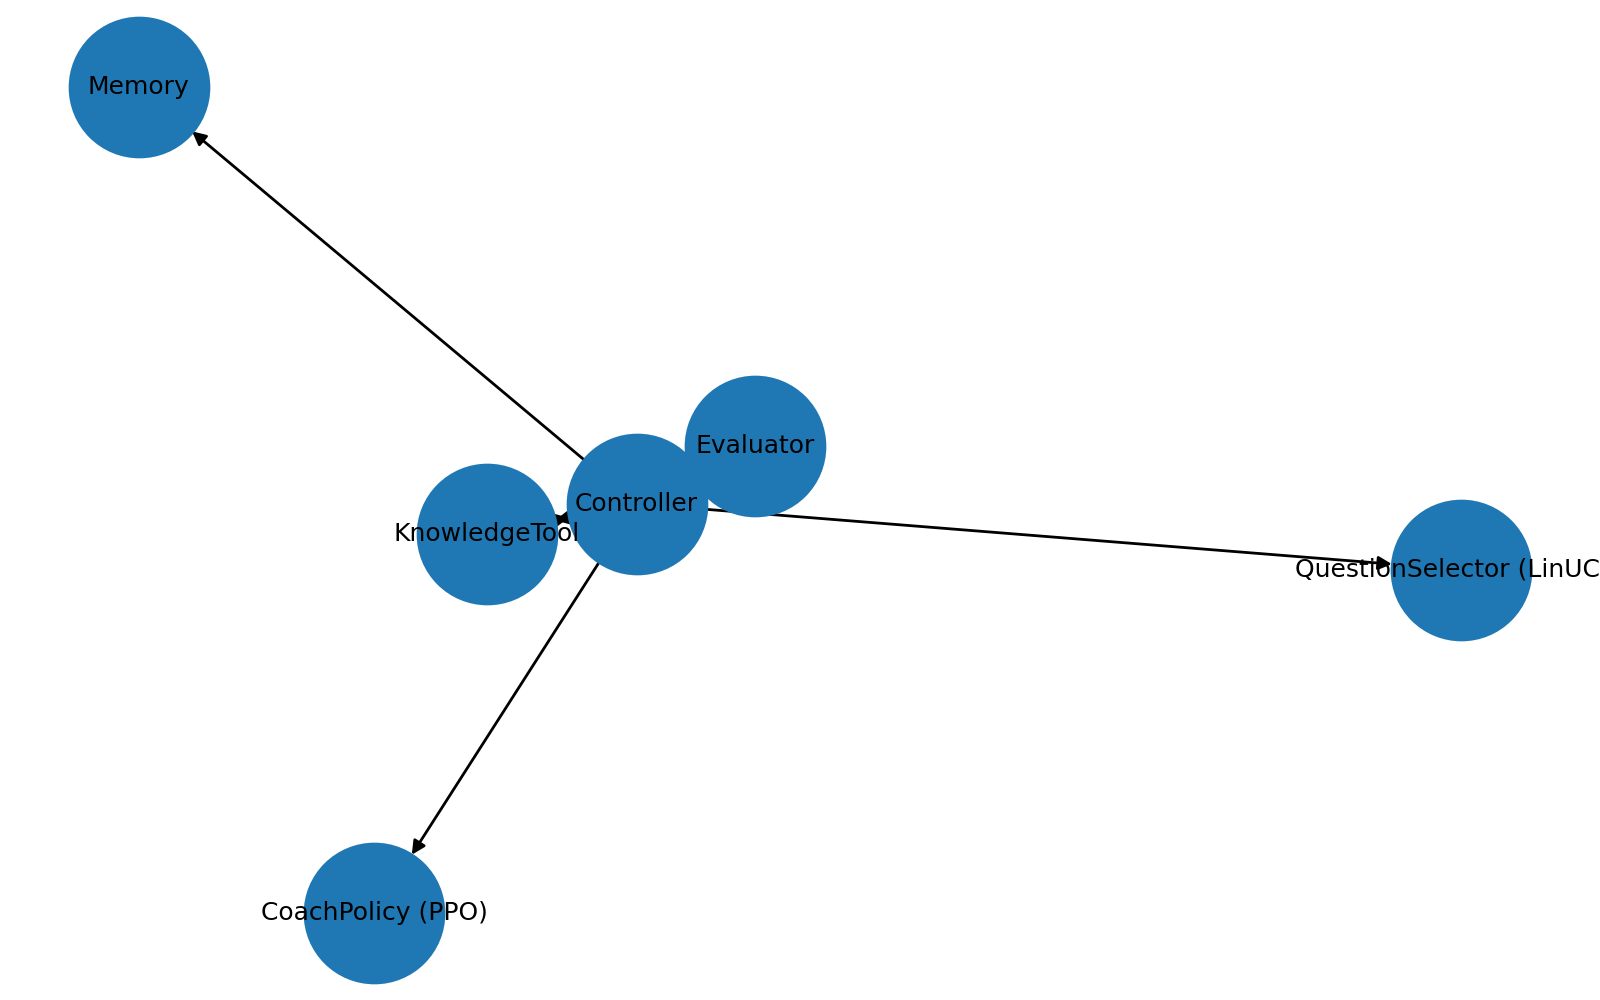

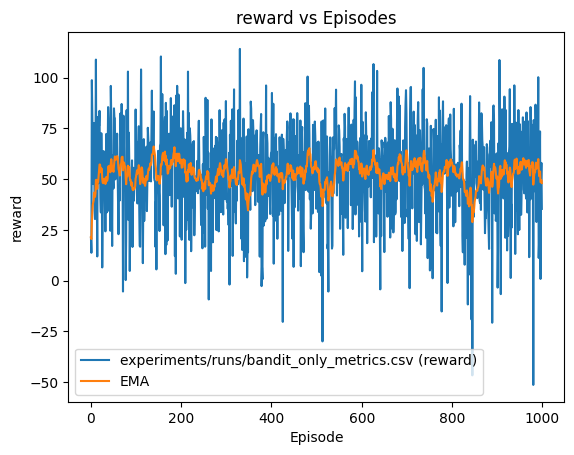

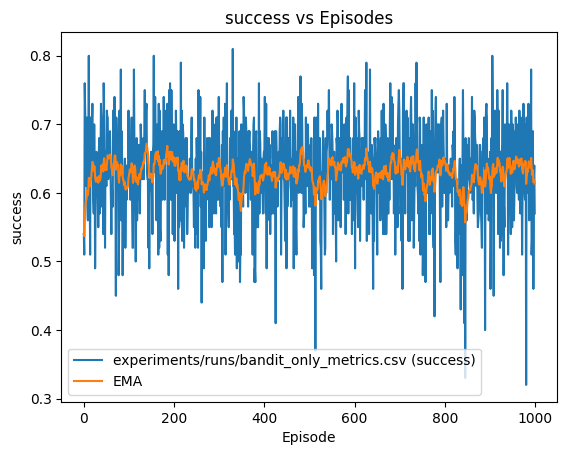

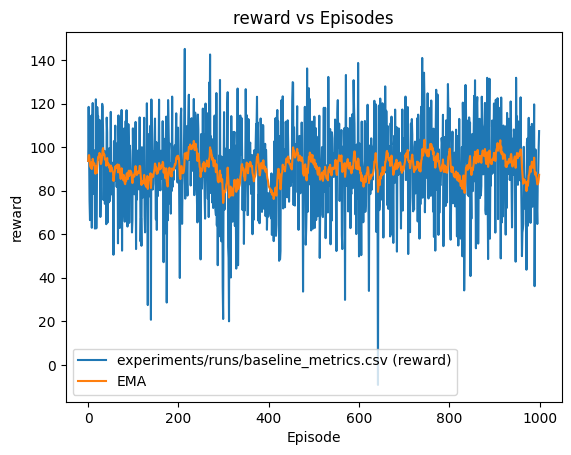

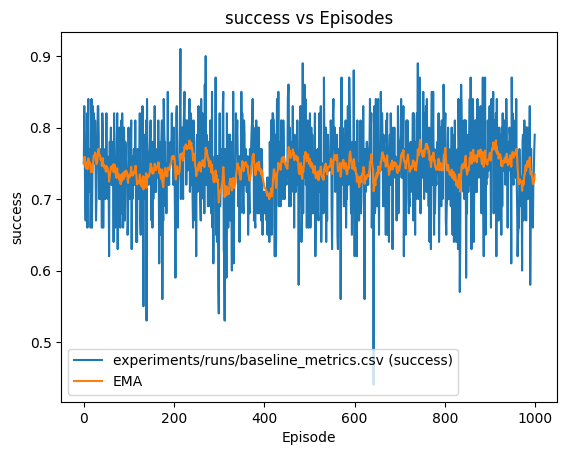

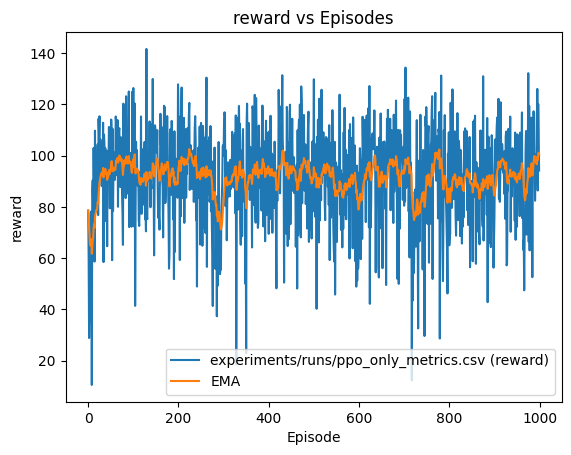

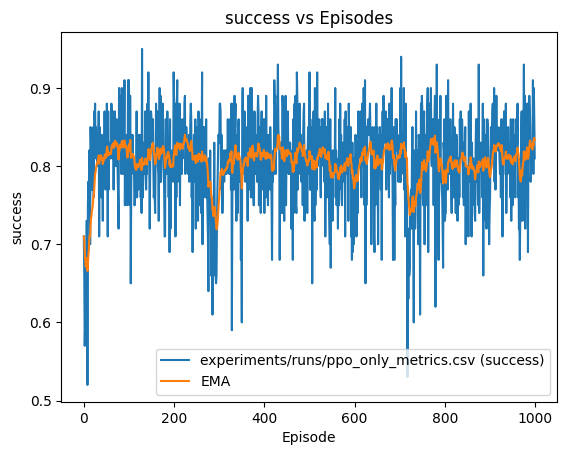

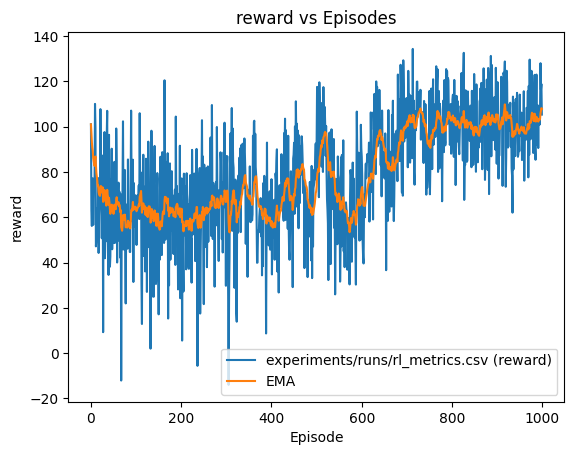

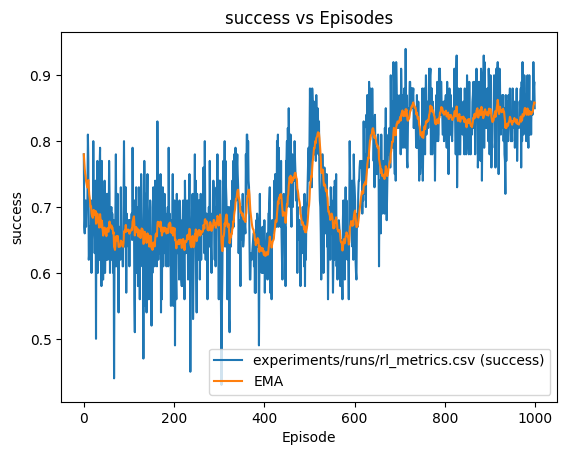

In [30]:
from IPython.display import Image, display
import glob

# Find all PNG plots in artifacts folder
plot_files = glob.glob("artifacts/*.png")

# Display each plot
for plot_file in plot_files:
    display(Image(filename=plot_file))
